# Thresholding Algorithm with Wavelet Dictionary

### Simple approach to denoising

As a simple baseline we use thresholding algorithm with wavelet dictionary.

$\hat{x} = D S_T(D^T z)$ ($S_T$ is hard thresholding operator)

For image quality we'll use Peak Signal-to-Noise Ration (PSNR) metric:

$PSNR(x, x_{noisy}) = 10 \cdot log_{10}(\frac{num\_pixels \cdot DR(x)^2}{\|x - x_{noisy}\|^2})$

Note that this is essentially equivalent to MSE error, only normalized by dynamic range and number of features(pixels).

Dynamic range is simply the range of pixel intensities: $DR(x) = max(x) - min(x)$

In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
%matplotlib inline

import skimage.io

In [2]:
np.random.seed(0) 

In [3]:
def threshold(x, threshold_value):
    return x * (np.abs(x) >= threshold_value)


def get_psnr(x, x_estimated):
    dynamic_range = x.max() - x.min()
    error = np.mean((x - x_estimated) ** 2)
    psnr_value = dynamic_range ** 2 / error
    return 10 * np.log10(psnr_value)


def restore_image_with_wavelet_thresholding(noisy_img, threshold_value, wavelet='haar'):
    coeffs = pywt.wavedecn(noisy_img, wavelet)
    coeffs_array, coeffs_shape = pywt.coeffs_to_array(coeffs)
    thresholded_coeffs_array = threshold(coeffs_array, threshold_value)
    num_coeff_nonzeros = (np.abs(thresholded_coeffs_array) > 0).sum()
    thresholded_coeffs = pywt.array_to_coeffs(thresholded_coeffs_array, coeffs_shape)
    return pywt.waverecn(thresholded_coeffs, wavelet), num_coeff_nonzeros


def show_grayscale_image(img, title=''):
    plt.imshow(img, cmap='gray');
    plt.axis('off');
    plt.title(title)
    plt.show()

In [4]:
url = 'https://homepages.cae.wisc.edu/~ece533/images/barbara.png'
img = skimage.io.imread(url)

sigma = 20.0
noisy_img = img + sigma * np.random.randn(*img.shape)

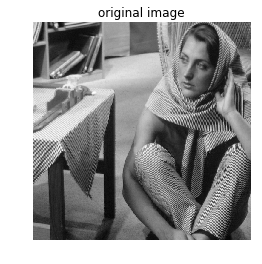

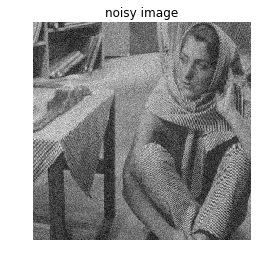

In [5]:
show_grayscale_image(img, 'original image')

show_grayscale_image(noisy_img, 'noisy image')

In [6]:
threshold_values = range(0, 200)

In [7]:
%%time
restored_imgs_with_nonzeros = [
    restore_image_with_wavelet_thresholding(noisy_img, thr, wavelet='db2')
    for thr in threshold_values
]

CPU times: user 4.72 s, sys: 169 ms, total: 4.88 s
Wall time: 4.88 s


In [8]:
restored_imgs, nonzeros_per_threshold = zip(*restored_imgs_with_nonzeros)

nonzeros_per_threshold_percent = 100 * np.array(nonzeros_per_threshold) / img.shape[0] ** 2

In [9]:
psnr_per_threshold = [
    get_psnr(img, restored_img)
    for restored_img in restored_imgs
]

In [10]:
best_threshold_value = threshold_values[np.argmax(psnr_per_threshold)]
best_restored_image = restore_image_with_wavelet_thresholding(noisy_img, best_threshold_value, wavelet='db2')[0]

noisy image psnr 21.38
best reconstruction psnr: 24.41
best threshold: 54


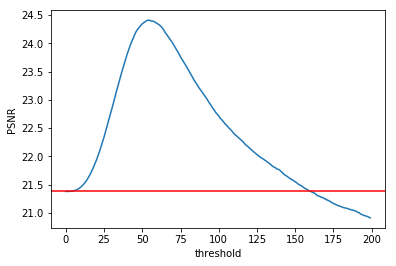

In [11]:
print('noisy image psnr', round(get_psnr(img, noisy_img), 2))
print('best reconstruction psnr:', round(get_psnr(img, best_restored_image), 2))
print('best threshold:', best_threshold_value)

plt.plot(threshold_values, psnr_per_threshold)
plt.axhline(y=get_psnr(img, noisy_img), color='r', linestyle='-')
plt.xlabel('threshold')
plt.ylabel('PSNR')
plt.show()

Best reconstruction uses 6.06% coefficients


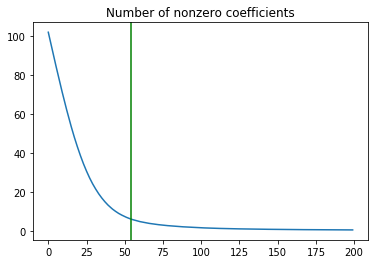

In [12]:
print('Best reconstruction uses', str(nonzeros_per_threshold_percent[best_threshold_value])[:4] + '%', 'coefficients')
plt.title('Number of nonzero coefficients')
plt.plot(threshold_values, nonzeros_per_threshold_percent)
plt.axvline(x=best_threshold_value, color='g');

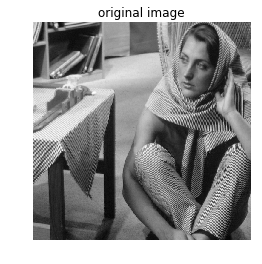

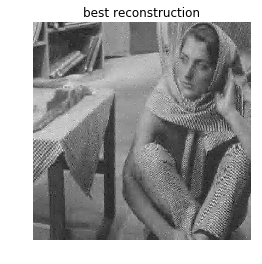

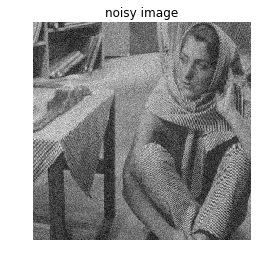

In [13]:
show_grayscale_image(img, 'original image')
show_grayscale_image(best_restored_image, 'best reconstruction')
show_grayscale_image(noisy_img, 'noisy image')